In [1]:
import json
# from yahoofinancials imp\`ort YahooFinancials as YF
import time
import datetime
import pandas as pd
# from pandas_datareader import data
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

from typing import List, Optional
import os
import pickle 
from tqdm import tqdm
import scipy.stats as sp
from utils import *
# from pydantic import BaseModelttt
# from backtester import *
# from backtest import *
import matplotlib.pyplot as plt
# import quandl
import math

%matplotlib inline
# %matplotlib notebook

In [2]:
tickers = ['AAPL','T', 'MSFT']
stocks = getStocksData(tickers, 100, save_new=False)
stocks[tickers[0]].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-19,176.389999,176.389999,174.940002,175.160004,174.923798,55772400
1,2023-05-22,173.979996,174.710007,173.449997,174.199997,173.965073,43570900
2,2023-05-23,173.130005,173.380005,171.279999,171.559998,171.328644,50747300
3,2023-05-24,171.089996,172.419998,170.520004,171.839996,171.608261,45143500
4,2023-05-25,172.410004,173.899994,171.690002,172.990005,172.756714,56058300


In [3]:
df = stocks[tickers[0]]
df.index

RangeIndex(start=0, stop=63, step=1)

bars
         Date       Open       High        Low      Close  Adj Close    Volume
0  2023-05-19  36.220001  36.520000  36.029999  36.049999  35.415993  16824900
1  2023-05-22  36.250000  36.330002  35.910000  35.959999  35.327576  16634300
2  2023-05-23  35.939999  36.910000  35.799999  36.240002  35.602654  21539700
3  2023-05-24  36.230000  36.250000  35.849998  35.869999  35.239159  16044200
4  2023-05-25  35.540001  35.560001  34.740002  34.820000  34.207626  32465900
..        ...        ...        ...        ...        ...        ...       ...
58 2023-08-14  33.189999  33.590000  33.139999  33.560001  33.560001  17934000
59 2023-08-15  33.349998  33.509998  33.209999  33.259998  33.259998  15528600
60 2023-08-16  33.299999  33.639999  33.139999  33.270000  33.270000  17395100
61 2023-08-17  33.360001  33.480000  32.849998  33.060001  33.060001  19128000
62 2023-08-18  32.860001  33.419998  32.860001  33.180000  33.180000  21718100

[63 rows x 7 columns]


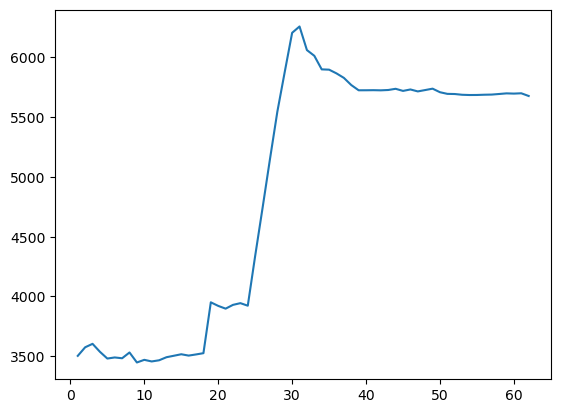

In [4]:
import pandas as pd
import math

class Stock:
    def __init__(self, ticker,df=None,initial_capital=1000, path=r"C:\Users\moyer\OneDrive\development\fin-dashboard\app\stocks.pkl"):
        self.ticker = ticker
        self.initial_capital = initial_capital
        self.isBankrupt = 0
        self.path = path
        self.savedBars = None
        with open(self.path, 'rb') as handle:
            self.savedBars = pickle.load(handle)
        self.df = df
        if (self.df == None):
            self.df = self.getStocksData(ticker)
        
        self.bars = self.df
        self.positions = pd.DataFrame(self.df.index)
       
        print("bars")
        print(self.bars)

    def getSavedData(self, ticker):
        with open(self.path, 'rb') as handle:
            stocks = pickle.load(handle)
            if self.ticker in stocks:
                return stocks[self.ticker]
            else:
                return None



    # gets stock ticket data for current day going back days_back
    def getStocksData(self,tickers, days_back=10, save_new=False):
        def convert_time(epoch):
            return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch))

        epoch_time = int(time.time())
        day_epoch = 60*60*24
        # check if data exists, if not pull data
        if (save_new or self.ticker not in self.savedBars):
            try:
                # download dataframe
                # data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
                print(f"Trying download of {self.ticker}")
                stock_data =  pdr.get_data_yahoo(self.ticker, period="3mo")
                stock_data = stock_data.reset_index()
                print(f"Downloaded bars of {self.ticker}")
                print(stock_data)
                self.savedBars[self.ticker] = stock_data
                with open(self.path, 'wb') as handle:
                    pickle.dump(self.savedBars, handle,
                                protocol=pickle.HIGHEST_PROTOCOL)
                return stock_data
            except:
                print("Skipping stock for {}, bad data :<".format(self.ticker))
        else:
            return self.savedBars[self.ticker]




    def macd(self, df, short=12, long=26):
        exp1 = df['Adj Close'].ewm(span=short, adjust=False).mean()
        exp2 = df['Adj Close'].ewm(span=long, adjust=False).mean()
        df['macd'] = exp1 - exp2
        df['macd_norm'] = (df['macd'] - df['macd'].min()) / (df['macd'].max() - df['macd'].min())
        return df['macd_norm']

    def backtest(self):
        macd1 = 500 * self.macd(self.df, 12, 23)
        macd2 = self.macd(self.df, 12, 43)
        macd3 = self.macd(self.df, 12, 53)
        strat1 = pd.DataFrame(self.bars.index)

        strat1 = pd.Series(500, index=self.bars.index)
        strategies = [macd1, macd2, macd3]

        self.positions[self.ticker + '_position'] = pd.concat(strategies).groupby(level=0).mean()
        self.positions[self.ticker + '_position'].at[0] = 0
        self.positions[self.ticker + '_open'] = self.bars.Open
        self.positions[self.ticker + '_close'] = self.bars.Close

        self.positions[self.ticker + '_pos_diff'] = self.positions[self.ticker + "_position"].diff()

        self.positions[self.ticker + "_cash_needed"] = self.positions[self.ticker + "_pos_diff"] * self.bars.Open
        self.positions[self.ticker + "_cash"] = self.initial_capital - self.positions[f'{self.ticker}_cash_needed'].cumsum()
        self.positions[self.ticker + "_holdings"] = 0
        self.positions[self.ticker + "_pos_diff_new"] = 0

        cash_held = self.initial_capital
        available_cash = self.initial_capital

        for index, row in self.positions.iterrows():
            if index == 0:
                continue

            price = row[self.ticker + "_open"]
            cash = self.positions.loc[index - 1][self.ticker + "_cash"]
            holdings = self.positions.loc[index - 1][self.ticker + "_holdings"]
            cash_needed = row[self.ticker + "_pos_diff"] * row[self.ticker + "_open"]

            if cash > cash_needed:
                cash = cash - cash_needed
                holdings = holdings + cash_needed
            else:
                new_pos_diff = cash / price
                self.positions.at[index, f"{self.ticker}_pos_diff_new"] = new_pos_diff
                cash = 0

            self.positions.at[index, f"{self.ticker}_holdings"] = holdings
            self.positions.at[index, f"{self.ticker}_cash"] = cash

        self.positions[f'{self.ticker}_holdings'] = self.positions[f"{self.ticker}_position"] * self.positions[f"{self.ticker}_open"]
        self.positions['total'] = self.positions[f"{self.ticker}_cash"] + self.positions[f"{self.ticker}_holdings"]

        self.positions = self.positions.round(2)

        self.positions.total.plot()

# Example usage
# df = ...  # Load your DataFrame here
initial_capital = 100000
ticker = 'VZ'

stock_instance = Stock(ticker,df=None,initial_capital = initial_capital)
stock_instance.backtest()


In [7]:
days_back=10
save_new=False
path=r"C:\Users\moyer\OneDrive\development\fin-dashboard\app\stocks.pkl"
with open(path, 'rb') as handle:
    stocks = pickle.load(handle)

stocks

{'AAPL':          Date        Open        High         Low       Close   Adj Close  \
 0  2023-05-19  176.389999  176.389999  174.940002  175.160004  174.923798   
 1  2023-05-22  173.979996  174.710007  173.449997  174.199997  173.965073   
 2  2023-05-23  173.130005  173.380005  171.279999  171.559998  171.328644   
 3  2023-05-24  171.089996  172.419998  170.520004  171.839996  171.608261   
 4  2023-05-25  172.410004  173.899994  171.690002  172.990005  172.756714   
 ..        ...         ...         ...         ...         ...         ...   
 58 2023-08-14  177.970001  179.690002  177.309998  179.460007  179.460007   
 59 2023-08-15  178.880005  179.479996  177.050003  177.449997  177.449997   
 60 2023-08-16  177.130005  178.539993  176.500000  176.570007  176.570007   
 61 2023-08-17  177.139999  177.509995  173.479996  174.000000  174.000000   
 62 2023-08-18  172.300003  175.100006  171.960007  174.490005  174.490005   
 
       Volume  
 0   55772400  
 1   43570900  
 2   5